In [1]:
#Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd        
import seaborn as sns
import keras #Wrapper de tensorflow (pytorch)
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.layers import Dense #Full-connected
from sklearn.cluster import KMeans
from sklearn import preprocessing
from yellowbrick.cluster import KElbowVisualizer
import warnings
import plotly as py
import plotly.io as pio
import plotly.express as px
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
#Cargamos el CSV
df = pd.read_csv('emisiones_co2.csv')

In [3]:
#Agregamos funcion para  que calcule si el indice de C02 cumple la normativa esperada
def ValidaNormativa(intCO2Vehiculo):


    intcumple = 0
    intCE02Norma=df["CO2"].median()#Cambiar por valor entregado, considerar mas columnas
    if (intCO2Vehiculo<=intCE02Norma):
        intcumple=1
    else:
        intcumple=0

    return intcumple


In [4]:
#Agregamos la nueva columna para validar si cumple la normativa esperada
#Remplazamos peso en blanco por mediana

df['Volume']=df['Volume'].replace(0,df['Volume'].median())

df["CumpleNormativa"] =df.apply(lambda x: ValidaNormativa(x["CO2"]),axis=1)



<AxesSubplot:xlabel='Volume'>

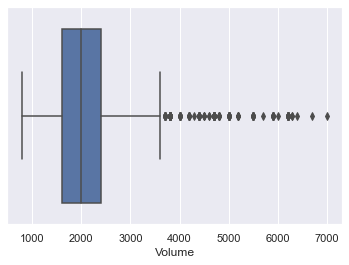

In [32]:
#Revisión outliner
sns.boxplot(x=df['Volume'])

<AxesSubplot:xlabel='Weight'>

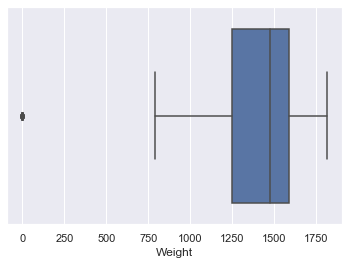

In [33]:
#Revisión outliner
sns.boxplot(x=df['Weight'])

<AxesSubplot:xlabel='CO2'>

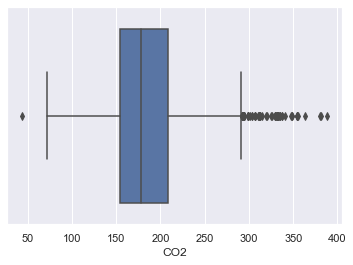

In [34]:
#Revisión outliner
sns.boxplot(x=df['CO2'])  

In [5]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Volume             800.0
Weight             341.0
CO2                 55.0
CumpleNormativa      1.0
dtype: float64


In [6]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

C:\Users\Eric Hutchinson\AppData\Local\Temp\ipykernel_12036\4147643536.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


(1754, 6)

In [8]:
X = df.iloc[:, 0:5].values #Primera columnas, no consideramos si cumple normativa o no
y = df.iloc[:, 5].values #Ultima columna para ver si cumple normativa
Le_Car = LabelEncoder()
X[:, 0] = Le_Car.fit_transform(X[:, 0])
Le_Model = LabelEncoder()
X[:, 1] = Le_Model.fit_transform(X[:, 1])
# ohe = OneHotEncoder(categorical_features=[1])
# X = ohe.fit_transform(X).toarray()
# # evitar trampa de variable irrrelevante ;)
# X = X[:, 1:]


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# print(X_train.shape)
# print(X_test-shape)
# 1). Hold-out: Dividir data de forma random en training-test (data muy grande)
# 2). (Stratified)K-Cross-Validation: Dividir data de forma random en K particiones balanceadas, se toman k-1 para training test y la restante para (data pequeña (100 datos) - grande) - [K Random Hold-Out ]
# 3). Leave-One-Out=K-CV con K=N. [muy pocos datos]. Discutido si es mejor que K-CV HW: Bootstrapping

In [10]:

sc = StandardScaler() #normalizacion Z
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#print(X_train)

In [11]:
# Crear clasificador ANN
classifier = Sequential()
# una regla de dedo gordo para determinar numero de nodos en capas ocultas (al comienzo) 
# es usar el promedio de numero de nodos de entrada y salida
classifier.add(Dense(units=6, input_dim=5, kernel_initializer='uniform', activation='relu')) #5 = numero de columnas
# agregar segunda capa oculta
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
# capa de salida
# en este caso usar como funcion de activacion sigmoide ya que requerimos tener probabilidades de salida
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid')) #Linear->regresion, relu->regresion (valores positivos)
# compile clasificador
# adam es una variante adaptiva de SGD
# crossentropy es la funcion de costo logaritmica de raices de Information Theory, para clasificacion binaria use 'binary_crossentropy' 
# para clasificacion multiclase use 'categorical_crossentropy'
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
classifier.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
141/141 [==============================] - 1s 1ms/step - loss: 0.6782 - accuracy: 0.5909
Epoch 2/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4986 - accuracy: 0.8582
Epoch 3/100
141/141 [==============================] - 0s 1ms/step - loss: 0.3053 - accuracy: 0.9116
Epoch 4/100
141/141 [==============================] - 0s 1ms/step - loss: 0.2051 - accuracy: 0.9294
Epoch 5/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1475 - accuracy: 0.9558
Epoch 6/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1027 - accuracy: 0.9736
Epoch 7/100
141/141 [==============================] - 0s 1ms/step - loss: 0.0743 - accuracy: 0.9822
Epoch 8/100
141/141 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.9893
Epoch 9/100
141/141 [==============================] - 0s 1ms/step - loss: 0.0502 - accuracy: 0.9907
Epoch 10/100
141/141 [==============================] - 0s 1ms/step - loss: 0.0444 - accura

In [43]:
y_pred = classifier.predict(X_train)
y_pred = (y_pred > 0.5)
print(confusion_matrix(y_train, y_pred))

44/44 [==============================] - 0s 948us/step
[[620   0]
 [  0 783]]


In [44]:
print(accuracy_score(y_train,y_pred))

1.0


In [45]:
y_predt = classifier.predict(X_test)
y_predt = (y_predt > 0.5)
print(confusion_matrix(y_test, y_predt))
print(accuracy_score(y_test,y_predt))

11/11 [==============================] - 0s 1ms/step
[[164   0]
 [  0 187]]
1.0


In [18]:
df.head()

,Car,Model,Volume,Weight,CO2,CumpleNormativa
0,Toyota,Aygo,1000,790,99,1
1,Mitsubishi,Space Star,1200,1160,95,1
2,Skoda,Citigo,1000,929,95,1
3,Fiat,500,900,865,90,1
4,Mini,Cooper,1500,1140,105,1


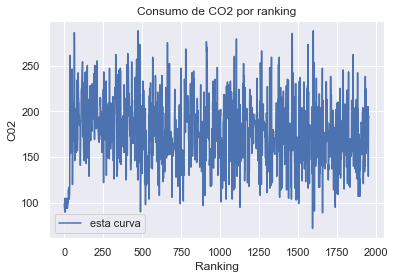

In [46]:
# Visualización de gráficas

df['CO2'].astype(float).plot()
plt.grid(True)
plt.xlabel("Ranking")
plt.ylabel("C02")
plt.title("Consumo de CO2 por ranking")
plt.legend(["esta curva"])

(array([1, 2]), [Text(1, 0, 'Volume'), Text(2, 0, 'Weight')])

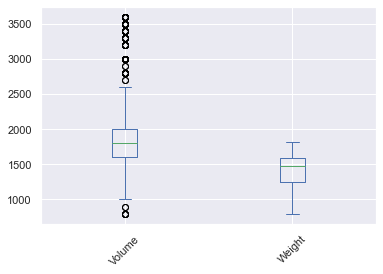

In [51]:
df_sin_varios = df.loc[:, ~df.columns.isin(['Car', 'Model', 'CO2','CumpleNormativa'])]
df_sin_varios.astype(float).plot(kind="box")
plt.xticks(rotation=45)

Text(0.5, 0.98, 'muchos histogramas')

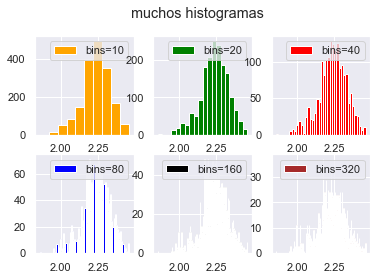

In [48]:
filas = 2
columnas = 3
cajitas = 10
contador = 0
colores = ['orange', 'green', 'red', 'blue', 'black', 'brown']
fig, axs = plt.subplots(filas, columnas)
for fil in range(filas):
  for col in range(columnas):
    axs[fil, col].hist(np.log10(df['CO2'].astype(float).values), bins=cajitas, color=colores[contador])
    axs[fil, col].legend(["bins=" + str(cajitas)])
    cajitas *= 2
    contador += 1
fig.suptitle("muchos histogramas")

In [18]:
enc = LabelEncoder()
temp = df.copy()
temp.iloc[:, 0]=enc.fit_transform(df.iloc[:, 0])
temp.iloc[:, 1]=enc.fit_transform(df.iloc[:, 1])
temp.head()

,Car,Model,Volume,Weight,CO2,CumpleNormativa
0,59,292,1000,790,99,1
1,48,1404,1200,1160,95,1
2,55,493,1000,929,95,1
3,20,80,900,865,90,1
4,47,514,1500,1140,105,1


In [19]:
#Regresion Lineal
target = temp[['CO2']].copy()
x2=temp[temp.columns[0:6]]

y2 = target["CO2"]
print(x2.shape)

(1754, 6)


In [20]:
lm = linear_model.LinearRegression()
model = lm.fit(x2,y2)

In [21]:
predictions = lm.predict(x2)
print(predictions[0:10])

[ 99.  95.  95.  90. 105. 105.  90.  92.  98.  99.]


In [26]:
lm.score(x2,y2)

1.0

In [27]:
lm.coef_

array([-2.44489651e-17, -1.56125113e-17,  1.12188494e-17, -4.90809060e-17,
        1.00000000e+00,  5.30891156e-16])

In [28]:
lm.intercept_

-5.684341886080802e-14

C:\Users\Eric Hutchinson\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Eric Hutchinson\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Eric Hutchinson\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

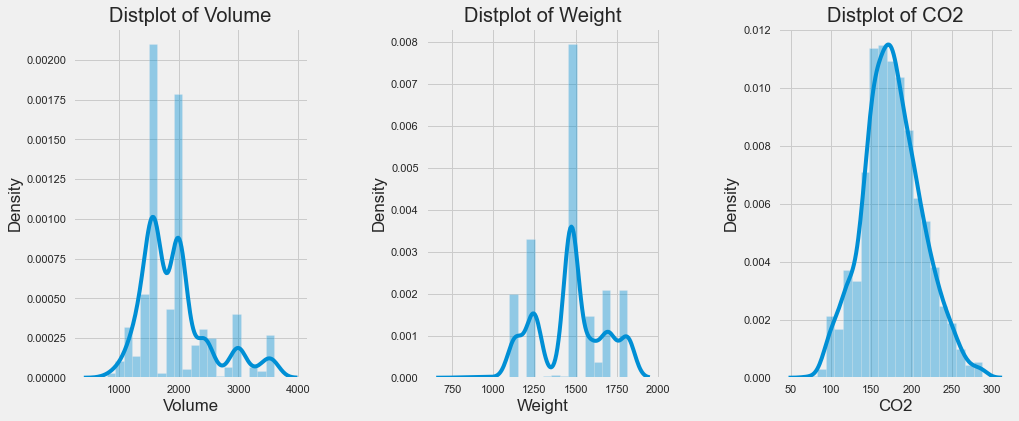

In [16]:
#temp.head()

plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Volume' , 'Weight' , 'CO2']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))

In [22]:
Xk = temp.copy()
X1 = preprocessing.normalize(X)

In [13]:
df.corr()

,Volume,Weight,CO2,CumpleNormativa
Volume,1.000000,-0.011082,0.626104,-0.532648
Weight,-0.011082,1.000000,-0.020467,0.012304
CO2,0.626104,-0.020467,1.000000,-0.790582
CumpleNormativa,-0.532648,0.012304,-0.790582,1.000000


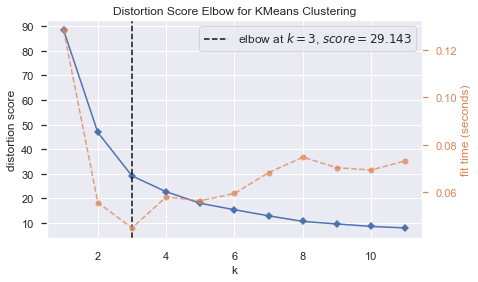

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X1)        # Entrenamos con los datos
visualizer.show()        # Renderizamos la imagen

In [23]:
algorithm = KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
algorithm.fit(X1)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_
df['label'] =  labels

In [24]:
y_kmeans= algorithm.predict(X1)

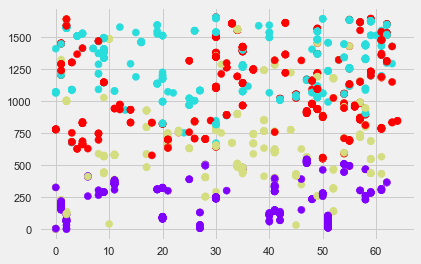

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

In [79]:
fig = px.scatter_3d(df, x='Volume', y='CO2', z='Weight',
              color='label')
fig.show()
